note : this notebook was further changed so the accuracy scores are different from the time of submition

#Introduction

This solution leverages satellite-derived Aerosol Optical Depth (AOD), meteorological reanalysis data, and machine learning (ML) techniques to estimate surface-level PM2.5 concentrations across space and time. By combining location-specific features (like latitude and longitude) with meteorological variables, the model captures local emission patterns and atmospheric dynamics. This data-driven approach enables high-resolution PM estimation, spatial mapping, and explainable insights through SHAP analysis, supporting policymakers in better air quality management.



#Dataset Information



1) Ground-Based PM2.5 Data


* Source: CPCB (Central Pollution Control Board)
* Purpose: Used as ground-truth labels for model training and validation

2) Satellite Data (AOD)
* Source: MERRA-2 (NASA)
* Purpose: Key input feature for estimating surface-level PM2.5 concentrations

3) Meteorological Reanalysis Data

* Source: ERA-5 (ECMWF) and MERRA-2 (NASA)
* Purpose: Provides weather-related features affecting PM2.5
distribution and dynamics


# Project Workflow

* Data Collection
* Data Preprocessing
* Feature Engineering
* Model Training and Evaluation
* Prediction & Visualization

#Importing Libraries

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler






# Data Import

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List all files and folders in 'MyDrive'
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/data/merged_data'))

['final_merged_data_v5.csv', 'final_merged_data_77.25,27.75,shyamnagar.csv', 'final_merged_data_76.5,27.5,Moti dongri.csv', 'final_merged_data_v3.csv', 'final_merged_data_v6.csv', 'final_merged_data_v7.csv']


In [ ]:
pbl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/pbl_multi.csv')
pbl.head()


,time,latitude,longitude,number,step,surface,valid_time,blh,tcc
0,2019-01-01 00:00:00,29.0,76.00,0,0 days,0.0,2019-01-01 00:00:00,20.352474,0.0
1,2019-01-01 00:00:00,29.0,76.25,0,0 days,0.0,2019-01-01 00:00:00,24.539974,0.0
2,2019-01-01 00:00:00,29.0,76.50,0,0 days,0.0,2019-01-01 00:00:00,30.352474,0.0
3,2019-01-01 00:00:00,29.0,76.75,0,0 days,0.0,2019-01-01 00:00:00,35.602474,0.0
4,2019-01-01 00:00:00,29.0,77.00,0,0 days,0.0,2019-01-01 00:00:00,44.977474,0.0


In [ ]:
pbl.columns


Index(['time', 'latitude', 'longitude', 'number', 'step', 'surface',
       'valid_time', 'blh', 'tcc'],
      dtype='object')

In [ ]:
pbl.drop(['number', 'step', 'surface',
       'valid_time'], axis=1, inplace = True)
pbl.head()

,time,latitude,longitude,blh,tcc
0,2019-01-01 00:00:00,29.0,76.00,20.352474,0.0
1,2019-01-01 00:00:00,29.0,76.25,24.539974,0.0
2,2019-01-01 00:00:00,29.0,76.50,30.352474,0.0
3,2019-01-01 00:00:00,29.0,76.75,35.602474,0.0
4,2019-01-01 00:00:00,29.0,77.00,44.977474,0.0


In [ ]:

coord = [[27.75,77.25],[27,78],[28.25,77.25],[28.25,77.75],[27.5,76.5],[28.75,77.75]]
77.25,28.75
coord_set = set(tuple(c) for c in coord)

# Assuming df has 'latitude' and 'longitude' columns
filtered_df = pbl[pbl.apply(lambda row: (row['latitude'], row['longitude']) in coord_set, axis=1)]

# Optional: Reset index
filtered_df.reset_index(drop=True, inplace=True)

filtered_df

,time,latitude,longitude,blh,tcc
0,2019-01-01 00:00:00,28.75,77.75,63.539974,0.000000
1,2019-01-01 00:00:00,28.25,77.25,45.227474,0.000000
2,2019-01-01 00:00:00,28.25,77.75,41.039974,0.000000
3,2019-01-01 00:00:00,27.75,77.25,37.727474,0.000000
4,2019-01-01 00:00:00,27.50,76.50,21.664974,0.000000
...,...,...,...,...,...
210379,2022-12-31 23:00:00,28.25,77.25,79.032900,0.966400
210380,2022-12-31 23:00:00,28.25,77.75,56.407898,0.967987
210381,2022-12-31 23:00:00,27.75,77.25,63.532898,0.449097
210382,2022-12-31 23:00:00,27.50,76.50,48.657898,0.143738


In [ ]:
filtered_df.head(10)


,time,latitude,longitude,blh,tcc
0,2019-01-01 00:00:00,28.75,77.75,63.539974,0.0
1,2019-01-01 00:00:00,28.25,77.25,45.227474,0.0
2,2019-01-01 00:00:00,28.25,77.75,41.039974,0.0
3,2019-01-01 00:00:00,27.75,77.25,37.727474,0.0
4,2019-01-01 00:00:00,27.50,76.50,21.664974,0.0
5,2019-01-01 00:00:00,27.00,78.00,30.914974,0.0
6,2019-01-01 01:00:00,28.75,77.75,63.471620,0.0
7,2019-01-01 01:00:00,28.25,77.25,45.159120,0.0
8,2019-01-01 01:00:00,28.25,77.75,40.534120,0.0
9,2019-01-01 01:00:00,27.75,77.25,39.034120,0.0


In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/data/merged_data'))


['final_merged_data_v5.csv', 'final_merged_data_77.25,27.75,shyamnagar.csv', 'final_merged_data_76.5,27.5,Moti dongri.csv', 'final_merged_data_v3.csv', 'final_merged_data_v6.csv', 'final_merged_data_v7.csv']


In [ ]:
# print(os.listdir('/content/drive/MyDrive/Colab Notebooks/data/76.5,27.5,Moti dongri/'))

mdoongri = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_76.5,27.5,Moti dongri.csv')
snagar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_77.25,27.75,shyamnagar.csv')
nise = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_v3.csv')
ricco = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_v5.csv')
avihar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_v6.csv')
spalace = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/merged_data/final_merged_data_v7.csv')



ricco.head()



,YEAR,MO,DY,HR,T2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M,AOD,Timestamp,PM2.5
0,2019,1,1,0,6.52,55.05,0.0,99.60,3.14,334.3,0.424665,2019-01-01 00:00:00,186.47
1,2019,1,1,1,5.99,56.24,0.0,99.58,3.04,333.6,0.428203,2019-01-01 01:00:00,176.47
2,2019,1,1,2,5.58,56.61,0.0,99.55,2.91,331.2,0.436397,2019-01-01 02:00:00,162.38
3,2019,1,1,3,5.29,56.48,0.0,99.50,2.80,326.7,0.446278,2019-01-01 03:00:00,153.12
4,2019,1,1,4,5.12,55.87,0.0,99.47,2.70,319.4,0.450686,2019-01-01 04:00:00,138.71


In [ ]:
# Step 1: Define coordinate-to-DataFrame map
coordinate_file_map = {
    (27.5, 76.5): mdoongri,
    (27.75, 77.25): snagar,
    (28.25, 77.25): nise,
    (28.25, 77.75): ricco,
    (28.75, 77.75): avihar,
    (27.0, 78.0): spalace
}

# Step 2: Ensure all timestamps are in same string format
for df in coordinate_file_map.values():
    df["Timestamp"] = pd.to_datetime(df["Timestamp"]).dt.strftime('%Y-%m-%d %H:%M:%S')

filtered_df["time"] = pd.to_datetime(filtered_df["time"]).dt.strftime('%Y-%m-%d %H:%M:%S')

# Step 3: Merge based on coordinates and timestamp
merged_parts = []

for (lat, lon), df in coordinate_file_map.items():
    # Filter main df for specific lat-lon
    subset_main = filtered_df[(filtered_df["latitude"] == lat) & (filtered_df["longitude"] == lon)].copy()

    # Merge on timestamp (time ↔ Timestamp)
    merged = pd.merge(subset_main, df, left_on="time", right_on="Timestamp", how="left")

    # Drop duplicate Timestamp column
    merged.drop(columns=["Timestamp"], inplace=True)

    merged_parts.append(merged)

# Step 4: Concatenate all merged chunks back
final_merged_df = pd.concat(merged_parts, ignore_index=True)

# final_merged_df now contains merged data for all 6 locations


/tmp/ipython-input-23-3248037785.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["time"]).dt.strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
final_merged_df.head(20)

,time,latitude,longitude,blh,tcc,YEAR,MO,DY,HR,T2M,RH2M,PRECTOTCORR,PS,WS10M,WD10M,AOD,PM2.5
0,2019-01-01 00:00:00,27.5,76.5,21.664974,0.000000,2019,1,1,0,9.36,28.93,0.0,97.24,2.14,11.3,0.205801,60.69
1,2019-01-01 01:00:00,27.5,76.5,19.721619,0.000000,2019,1,1,1,8.90,30.24,0.0,97.22,2.13,12.7,0.205127,56.60
2,2019-01-01 02:00:00,27.5,76.5,17.694477,0.000000,2019,1,1,2,8.58,31.03,0.0,97.19,2.07,17.4,0.202401,43.72
3,2019-01-01 03:00:00,27.5,76.5,16.824774,0.000000,2019,1,1,3,8.42,31.36,0.0,97.15,1.98,22.6,0.198865,12.69
4,2019-01-01 04:00:00,27.5,76.5,60.435930,0.000000,2019,1,1,4,8.72,30.72,0.0,97.12,1.74,27.5,0.195900,48.19
5,2019-01-01 05:00:00,27.5,76.5,258.030940,0.000000,2019,1,1,5,9.00,30.02,0.0,97.15,1.27,30.8,0.194461,44.55
6,2019-01-01 06:00:00,27.5,76.5,499.059330,0.000000,2019,1,1,6,9.90,28.27,0.0,97.21,0.71,37.5,0.240101,45.14
7,2019-01-01 07:00:00,27.5,76.5,724.189450,0.000000,2019,1,1,7,11.07,26.64,0.0,97.28,0.35,110.0,0.242555,44.67
8,2019-01-01 08:00:00,27.5,76.5,884.140870,0.000000,2019,1,1,8,13.88,23.05,0.0,97.34,0.87,156.4,0.243772,66.71
9,2019-01-01 09:00:00,27.5,76.5,1034.633000,0.000000,2019,1,1,9,17.29,17.58,0.0,97.35,1.36,158.4,0.234900,65.18


# Corelation Heatmap and further Processing

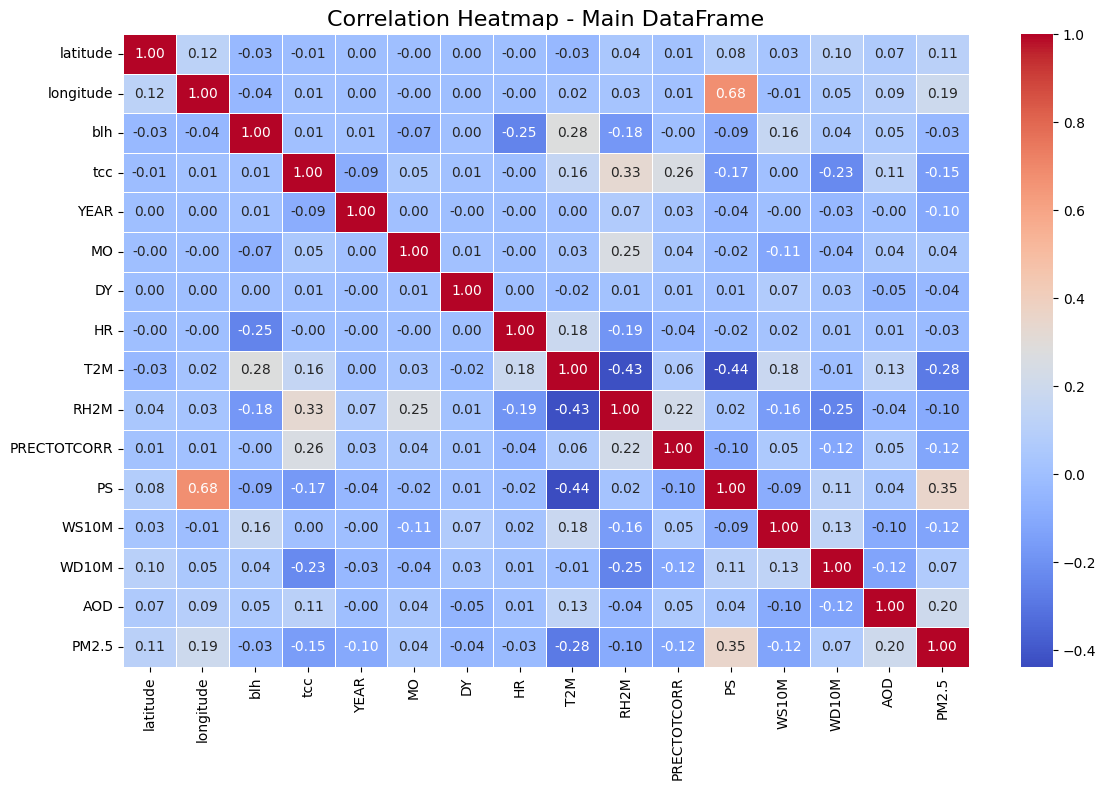

In [ ]:
# Compute correlation matrix for numeric columns
corr_matrix = final_merged_df.corr(numeric_only=True)

# Set plot size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title
plt.title("Correlation Heatmap - Main DataFrame", fontsize=16)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
df = final_merged_df
# df.head()

In [ ]:
# Define lower and upper bounds
lower_bound = 0
upper_bound = 600

# Filter data to remove outliers
df_filtered = df[(df['PM2.5'] >= lower_bound) & (df['PM2.5'] <= upper_bound)]

# Print shape before and after to confirm
print("Original shape:", df.shape)
print("Filtered shape:", df_filtered.shape)
print(lower_bound)
print(upper_bound)

Original shape: (210384, 17)
Filtered shape: (193259, 17)
0
600


In [ ]:
df = df_filtered
df = df.drop(['PRECTOTCORR'], axis = 1)

# Testing different models



In [ ]:
# Step 1: Drop non-numeric or irrelevant columns
df = df.copy()
df = df.drop(columns=["time"], errors="ignore")

# Step 2: Drop rows with missing values
df = df.dropna()

# Step 3: Separate features and target
X = df.drop("PM2.5", axis=1)
y = df["PM2.5"]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# XGboost

# Train XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 1075.48
Root Mean Squared Error (RMSE): 32.79
Mean Absolute Error (MAE): 20.71
R² Score: 0.72


In [ ]:
#LightGBM
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
df = final_merged_df.copy()
df = df.drop(columns=["time"], errors="ignore")
df = df.dropna()

X = df.drop("PM2.5", axis=1)
y = df["PM2.5"]

# Use only numeric features
X = X.select_dtypes(include=[np.number])

# Optional: scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Train LightGBM model with default hyperparameters
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ LightGBM Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 154728, number of used features: 15
[LightGBM] [Info] Start training from score 70.142162


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ LightGBM Results:
Mean Squared Error (MSE): 1450.88
Root Mean Squared Error (RMSE): 38.09
Mean Absolute Error (MAE): 23.03
R² Score: 0.66


In [ ]:
# reinitializing data
df = final_merged_df.copy()
df = df.drop(columns=["time"], errors="ignore")
df = df.dropna()

X = df.drop("PM2.5", axis=1)
y = df["PM2.5"]

# Use only numeric features
X = X.select_dtypes(include=[np.number])

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Gradient Boost

# Train Gradient Boosting model with default hyperparameters
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Gradient Boosting Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


✅ Gradient Boosting Results:
Mean Squared Error (MSE): 2295.22
Root Mean Squared Error (RMSE): 47.91
Mean Absolute Error (MAE): 28.61
R² Score: 0.47


In [ ]:
# Random Forest (our hero)
from sklearn.ensemble import RandomForestRegressor

#  Train Random Forest model with default hyperparameters
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Random Forest Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


✅ Random Forest Results:
Mean Squared Error (MSE): 808.28
Root Mean Squared Error (RMSE): 28.43
Mean Absolute Error (MAE): 15.04
R² Score: 0.81


In [ ]:
# Cat boost
from catboost import CatBoostRegressor

# Train CatBoost model with default hyperparameters
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ CatBoost Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


✅ CatBoost Results:
Mean Squared Error (MSE): 1269.77
Root Mean Squared Error (RMSE): 35.63
Mean Absolute Error (MAE): 20.95
R² Score: 0.71


In [ ]:
#Adaptive boosting
from sklearn.ensemble import AdaBoostRegressor

# Step 3: Train AdaBoost model with default hyperparameters
model = AdaBoostRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ AdaBoost Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


✅ AdaBoost Results:
Mean Squared Error (MSE): 5749.02
Root Mean Squared Error (RMSE): 75.82
Mean Absolute Error (MAE): 59.65
R² Score: -0.33


We will tune XGBoost as XGBoost is the fastest among all and give good results.

# Hyper Parameter Tuning (XGBoost)


In [ ]:
# Step 1: Drop non-numeric or irrelevant columns
df = df.copy()
df = df.drop(columns=["time"], errors="ignore")

# Step 2: Drop rows with missing values
df = df.dropna()

# Step 3: Separate features and target
X = df.drop("PM2.5", axis=1)
y = df["PM2.5"]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We are tuning one hyperparameter at a time, since it provides more control for trying different combination and it is time inexpensive

In [ ]:
# Define n_estimators values to test
n_estimators_list = [ 500, 1000, 2000]

# Step 4: Iterate through different n_estimators
print("🔁 Evaluating different n_estimators:\n")
for n in n_estimators_list:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"n_estimators = {n}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


🔁 Evaluating different n_estimators:

n_estimators = 500
  MSE  = 883.11
  RMSE = 29.72
  MAE  = 18.80
  R²   = 0.7686
----------------------------------------
n_estimators = 1000
  MSE  = 833.25
  RMSE = 28.87
  MAE  = 18.35
  R²   = 0.7816
----------------------------------------
n_estimators = 2000
  MSE  = 813.36
  RMSE = 28.52
  MAE  = 18.15
  R²   = 0.7868
----------------------------------------


In [ ]:
# Define max_depth values to test
max_depth_list = [2, 3, 5, 7, 10, 12]

# Iterate through different max_depth values
print("🔁 Evaluating different max_depth values:\n")
for depth in max_depth_list:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=depth,
        n_estimators=100,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"max_depth = {depth}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


🔁 Evaluating different max_depth values:

max_depth = 2
  MSE  = 1985.81
  RMSE = 44.56
  MAE  = 28.71
  R²   = 0.4796
----------------------------------------
max_depth = 3
  MSE  = 1671.81
  RMSE = 40.89
  MAE  = 25.88
  R²   = 0.5619
----------------------------------------
max_depth = 5
  MSE  = 1253.11
  RMSE = 35.40
  MAE  = 22.24
  R²   = 0.6716
----------------------------------------
max_depth = 7
  MSE  = 969.46
  RMSE = 31.14
  MAE  = 19.64
  R²   = 0.7459
----------------------------------------
max_depth = 10
  MSE  = 720.87
  RMSE = 26.85
  MAE  = 16.75
  R²   = 0.8111
----------------------------------------
max_depth = 12
  MSE  = 644.44
  RMSE = 25.39
  MAE  = 15.53
  R²   = 0.8311
----------------------------------------


combining optimum values of both hyperparameters

In [ ]:
# Define and train model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=12,
    n_estimators=2000,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Model with max_depth=12 and n_estimators=2000")
print(f"📉 MSE  = {mse:.2f}")
print(f"📈 RMSE = {rmse:.2f}")
print(f"📊 MAE  = {mae:.2f}")
print(f"📈 R²   = {r2:.4f}")


✅ Model with max_depth=12 and n_estimators=2000
📉 MSE  = 633.88
📈 RMSE = 25.18
📊 MAE  = 15.36
📈 R²   = 0.8339


In [ ]:
# Define learning_rate values to test
learning_rates = [0.3,0.4,0.6,1]

# Step 4: Iterate through different learning_rate values
print("Evaluating different learning_rate values:\n")
for lr in learning_rates:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=lr,
        n_estimators=2000,  # fixed number of trees
        max_depth=12,       # fixed depth
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"learning_rate = {lr}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


Evaluating different learning_rate values:

learning_rate = 0.3
  MSE  = 633.88
  RMSE = 25.18
  MAE  = 15.36
  R²   = 0.8339
----------------------------------------
learning_rate = 0.4
  MSE  = 680.28
  RMSE = 26.08
  MAE  = 16.15
  R²   = 0.8217
----------------------------------------
learning_rate = 0.6
  MSE  = 847.64
  RMSE = 29.11
  MAE  = 18.40
  R²   = 0.7779
----------------------------------------
learning_rate = 1
  MSE  = 1340.52
  RMSE = 36.61
  MAE  = 24.09
  R²   = 0.6487
----------------------------------------


optimum learning rate = 0.4 or 0.3

In [ ]:
# Define subsample values to test
subsample_values = [0.5, 0.6, 0.8, 1.0]

# Iterate through different subsample values
print(" Evaluating different subsample values:\n")
for subsample in subsample_values:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        subsample=subsample,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"subsample = {subsample}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


 Evaluating different subsample values:

subsample = 0.5
  MSE  = 586.89
  RMSE = 24.23
  MAE  = 14.57
  R²   = 0.8462
----------------------------------------
subsample = 0.6
  MSE  = 570.08
  RMSE = 23.88
  MAE  = 14.28
  R²   = 0.8506
----------------------------------------
subsample = 0.8
  MSE  = 544.23
  RMSE = 23.33
  MAE  = 13.82
  R²   = 0.8574
----------------------------------------
subsample = 1.0
  MSE  = 550.80
  RMSE = 23.47
  MAE  = 14.00
  R²   = 0.8556
----------------------------------------


In [ ]:
# Define colsample_bytree values to test
colsample_values = [0.4, 0.6, 0.8, 1.0]

# Iterate through different colsample_bytree values
print("Evaluating different colsample_bytree values:\n")
for colsample in colsample_values:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=colsample,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"colsample_bytree = {colsample}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


Evaluating different colsample_bytree values:

colsample_bytree = 0.4
  MSE  = 916.29
  RMSE = 30.27
  MAE  = 18.27
  R²   = 0.7599
----------------------------------------
colsample_bytree = 0.6
  MSE  = 620.54
  RMSE = 24.91
  MAE  = 14.81
  R²   = 0.8374
----------------------------------------
colsample_bytree = 0.8
  MSE  = 551.32
  RMSE = 23.48
  MAE  = 14.01
  R²   = 0.8555
----------------------------------------
colsample_bytree = 1.0
  MSE  = 544.23
  RMSE = 23.33
  MAE  = 13.82
  R²   = 0.8574
----------------------------------------


In [ ]:
# Define gamma values to test
gamma_values = [0.1, 0.2, 0.5, 1]

# Iterate through different gamma values
print(" Evaluating different gamma values:\n")
for gamma in gamma_values:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        gamma=gamma,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"gamma = {gamma}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


 Evaluating different gamma values:

gamma = 0.1
  MSE  = 551.31
  RMSE = 23.48
  MAE  = 13.97
  R²   = 0.8555
----------------------------------------
gamma = 0.2
  MSE  = 549.56
  RMSE = 23.44
  MAE  = 13.97
  R²   = 0.8560
----------------------------------------
gamma = 0.5
  MSE  = 553.31
  RMSE = 23.52
  MAE  = 14.01
  R²   = 0.8550
----------------------------------------
gamma = 1
  MSE  = 550.55
  RMSE = 23.46
  MAE  = 13.99
  R²   = 0.8557
----------------------------------------


In [ ]:
# Define reg_alpha values to test
reg_alpha_values = [0.01, 0.1, 1, 10]

# Iterate through different reg_alpha values
print(" Evaluating different reg_alpha values:\n")
for alpha in reg_alpha_values:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        reg_alpha=alpha,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"reg_alpha = {alpha}")
    print(f"  MSE  = {mse:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R²   = {r2:.4f}")
    print("-" * 40)


 Evaluating different reg_alpha values:

reg_alpha = 0.01
  MSE  = 548.60
  RMSE = 23.42
  MAE  = 13.91
  R²   = 0.8562
----------------------------------------
reg_alpha = 0.1
  MSE  = 543.82
  RMSE = 23.32
  MAE  = 13.88
  R²   = 0.8575
----------------------------------------
reg_alpha = 1
  MSE  = 543.34
  RMSE = 23.31
  MAE  = 13.86
  R²   = 0.8576
----------------------------------------
reg_alpha = 10
  MSE  = 533.33
  RMSE = 23.09
  MAE  = 13.65
  R²   = 0.8602
----------------------------------------


reg_lambda = 0, RMSE = 23.2096
reg_lambda = 0.1, RMSE = 23.2924
reg_lambda = 0.5, RMSE = 23.1153
reg_lambda = 5, RMSE = 22.7382
reg_lambda = 10, RMSE = 22.8558


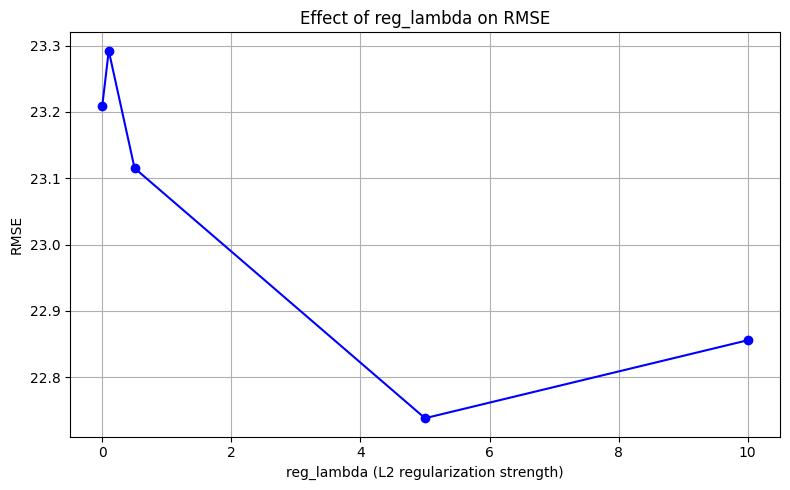

In [ ]:
# Define reg_lambda values to test
reg_lambda_values = [0, 0.1, 0.5, 5, 10]
rmse_list = []

# Iterate and collect RMSE
for lam in reg_lambda_values:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        reg_lambda=lam,
        reg_alpha= 10,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

    print(f"reg_lambda = {lam}, RMSE = {rmse:.4f}")

# Plot reg_lambda vs RMSE
plt.figure(figsize=(8, 5))
plt.plot(reg_lambda_values, rmse_list, marker='o', linestyle='-', color='blue')
plt.title("Effect of reg_lambda on RMSE")
plt.xlabel("reg_lambda (L2 regularization strength)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


 Evaluating different min_child_weight values:

min_child_weight = 3 | RMSE = 23.0284 | R² = 0.8610
min_child_weight = 5 | RMSE = 23.0616 | R² = 0.8606
min_child_weight = 7 | RMSE = 23.1691 | R² = 0.8593
min_child_weight = 10 | RMSE = 23.1431 | R² = 0.8596


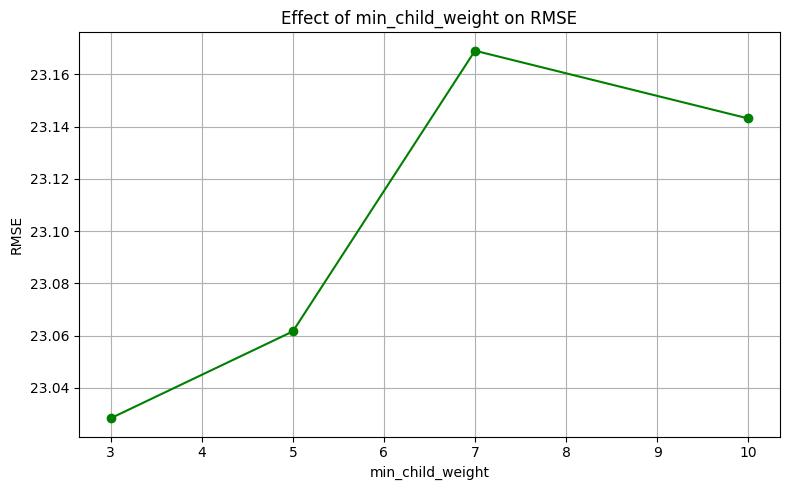

In [ ]:
# Define min_child_weight values to test
min_child_weights = [3, 5, 7, 10]

rmse_list = []
r2_list = []

# Iterate and collect RMSE and R²
print(" Evaluating different min_child_weight values:\n")
for mcw in min_child_weights:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        min_child_weight=mcw,
        reg_lambda=5,
        reg_alpha= 10,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"min_child_weight = {mcw} | RMSE = {rmse:.4f} | R² = {r2:.4f}")

# Plot min_child_weight vs RMSE
plt.figure(figsize=(8, 5))
plt.plot(min_child_weights, rmse_list, marker='o', linestyle='-', color='green')
plt.title("Effect of min_child_weight on RMSE")
plt.xlabel("min_child_weight")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()



in the previous loop: the default value of min_child_weight = 1 gave better result than any of these values

We are leaving the default values of hyperparameters because those values are already included in the previous loops

# GridSearch


In [ ]:
#  Define parameter grid
param_grid = {
    'n_estimators': [1000, 2000],
    'max_depth': [10,12],
    'reg_lambda': [5,10],
    'reg_alpha': [10, 20],
    'subsample': [0.8,1]
}

# Fixed parameters
fixed_params = {
    'learning_rate' :0.1,
    'colsample_bytree': 1.0,
    'reg_alpha': 0,
    'min_child_weight': 3,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Step 3: XGBoost Regressor
model = xgb.XGBRegressor(**fixed_params)

# Step 4: Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
)

grid_search.fit(X_train, y_train)

# Step 5: Evaluate Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)
print(f"\n📉 RMSE on Test Set: {rmse:.4f}")
print(f"📈 R² Score: {r2:.4f}")




✅ Best Parameters Found:
{'max_depth': 12, 'n_estimators': 2000, 'reg_alpha': 20, 'reg_lambda': 10, 'subsample': 0.8}

📉 RMSE on Test Set: 22.5282
📈 R² Score: 0.8670


took 5 hrs to run



# GridSearch Results


In [ ]:

# Define and train XGBoost model with chosen hyperparameters

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=12,
    n_estimators=2000,
    reg_lambda=10,
    reg_alpha=20,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" Model with max_depth=12 and n_estimators=2000")
print(f" MSE  = {mse:.2f}")
print(f" RMSE = {rmse:.2f}")
print(f" MAE  = {mae:.2f}")
print(f" R²   = {r2:.4f}")



 Model with max_depth=12 and n_estimators=2000
 MSE  = 507.52
 RMSE = 22.53
 MAE  = 13.41
 R²   = 0.8670


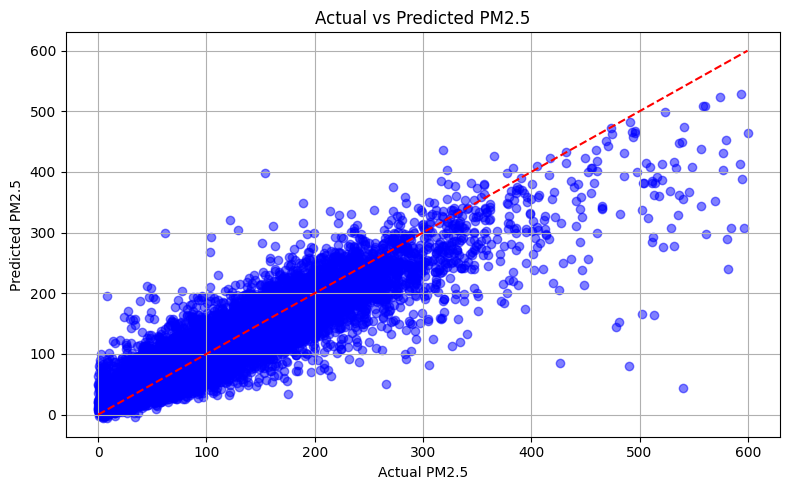

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()


# K-Fold CV

In [ ]:
# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mse_scores = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=12,
    n_estimators=2000,
    reg_lambda=10,
    reg_alpha=20,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)


    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"Fold {fold} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

# Final averaged results
print("\n📊 Final 5-Fold CV Summary:")
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")


Fold 1 | RMSE: 22.6847 | R²: 0.8651
Fold 2 | RMSE: 23.0311 | R²: 0.8648
Fold 3 | RMSE: 23.2168 | R²: 0.8598
Fold 4 | RMSE: 22.9455 | R²: 0.8626
Fold 5 | RMSE: 22.5409 | R²: 0.8647

📊 Final 5-Fold CV Summary:
Average MSE: 523.7269
Average RMSE: 22.8838
Average R²: 0.8634


#  Loading Testing Dataframe (2025-05-01)

In [ ]:
# import data to predict and plot PM2.5 values using our existing model
url = 'https://drive.google.com/file/d/1ii5u-hposNj83JKKD2_TwNVp0ANP4Fv5/view?usp=sharing'

# Convert to direct download link
file_id = url.split('/d/')[1].split('/')[0]
download_url = f'https://drive.google.com/uc?id={file_id}'

# Read into DataFrame
df_testing = pd.read_csv(download_url)
df_testing

,latitude,longitude,WD10M,WS10M,PS,RH2M,T2M,blh,AOD,YEAR,MO,DY,HR
0,18.0,73.75,329.8,3.57,94.13,38.58,31.11,589.892548,0.284963,2025,5,1,1
1,18.0,75.00,347.1,3.97,94.62,24.16,33.57,1444.225943,0.298707,2025,5,1,1
2,18.0,76.25,10.9,4.44,94.28,18.40,33.83,1282.913387,0.348997,2025,5,1,1
3,18.0,77.50,12.8,2.62,94.59,22.26,34.06,963.621717,0.414640,2025,5,1,1
4,18.0,78.75,161.6,4.30,95.43,38.38,33.52,852.236305,0.508945,2025,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,27.0,77.50,102.6,4.51,98.44,30.36,32.83,866.715467,0.665902,2025,5,1,1
148,27.0,78.75,100.2,4.59,99.00,33.83,32.53,928.309223,0.730507,2025,5,1,1
149,27.0,80.00,93.3,5.15,99.21,36.07,32.32,980.152978,0.828042,2025,5,1,1
150,27.0,81.25,91.3,5.84,99.51,39.05,31.55,936.642567,0.907733,2025,5,1,1


In [ ]:
# Step 1: Drop non-numeric or irrelevant columns
df = df.copy()
df = df.drop(columns=["time","tcc"], errors="ignore")

# Step 2: Drop rows with missing values
df = df.dropna()

# Step 3: Separate features and target
X = df.drop("PM2.5", axis=1)
y = df["PM2.5"]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=12,
    n_estimators=2000,
    reg_lambda=10,
    reg_alpha=20,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"  MSE  = {mse:.2f}")
print(f"  RMSE = {rmse:.2f}")
print(f"  MAE  = {mae:.2f}")
print(f"  R²   = {r2:.4f}")
print("-" * 40)


  MSE  = 513.06
  RMSE = 22.65
  MAE  = 13.47
  R²   = 0.8655
----------------------------------------


# Preparing Test Data and Predicting PM2.5  on testing Data

In [ ]:
# Prepare test data
test_df_clean = df_testing.copy()

# Drop non-numeric or irrelevant columns if needed
test_df_clean = test_df_clean.drop(columns=["time"], errors="ignore")

# Drop rows with missing values
test_df_clean = test_df_clean.dropna()

# Ensure columns match training features
X_test_new = test_df_clean[X_train.columns]

# Predict using trained model
y_pred_new = model.predict(X_test_new)

# Add predictions to your test dataframe
test_df_clean["Predicted_PM2.5"] = y_pred_new

# heatMap of predicted PM 2.5

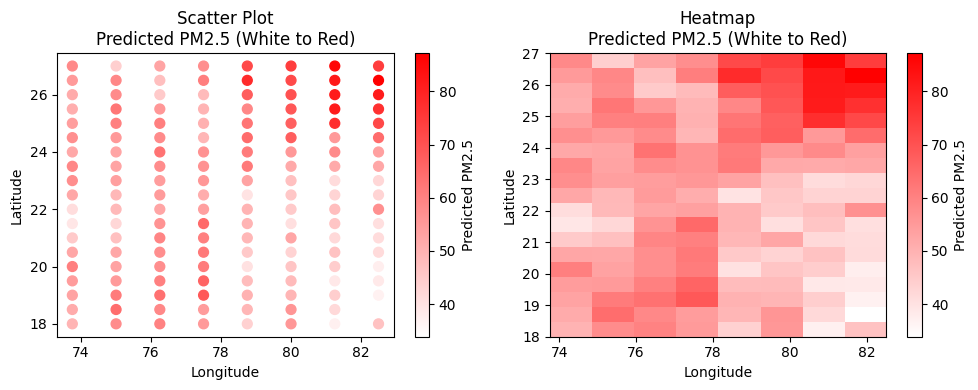

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom white-to-red colormap
white_red = LinearSegmentedColormap.from_list('white_red', ['white', 'red'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter Plot
sc = axes[0].scatter(test_df_clean['longitude'], test_df_clean['latitude'],
                     c=test_df_clean['Predicted_PM2.5'], cmap=white_red, s=50)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Scatter Plot\nPredicted PM2.5 (White to Red)')
cbar1 = fig.colorbar(sc, ax=axes[0], label='Predicted PM2.5')

# Heatmap
heatmap_df = test_df_clean.pivot_table(index='latitude', columns='longitude', values='Predicted_PM2.5')

im = axes[1].imshow(heatmap_df, cmap=white_red, aspect='auto',
                    extent=[heatmap_df.columns.min(), heatmap_df.columns.max(),
                            heatmap_df.index.min(), heatmap_df.index.max()],
                    origin='lower')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Heatmap\nPredicted PM2.5 (White to Red)')
cbar2 = fig.colorbar(im, ax=axes[1], label='Predicted PM2.5')

plt.tight_layout()
plt.show()

# Residuals Distribution

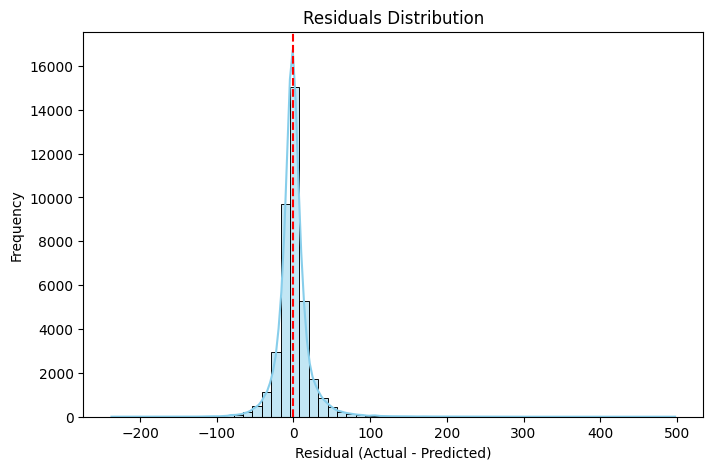

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=60, color='skyblue')
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Predicted vs Actual PM2.5

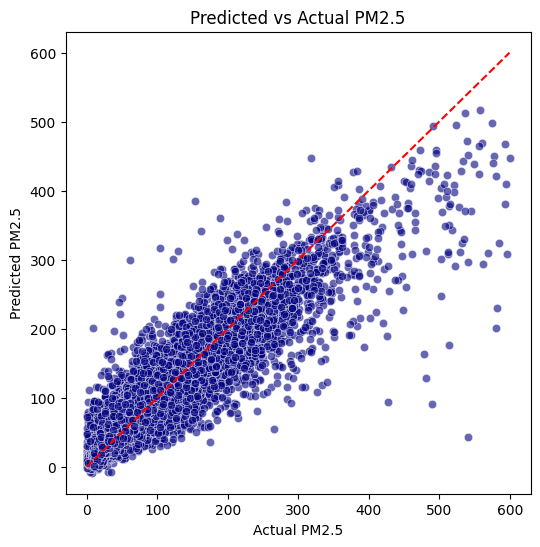

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, color='navy', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y=x line
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Predicted vs Actual PM2.5")
plt.show()


# SHAP Analysis

100%|===================| 999/1000 [15:18<00:00]       

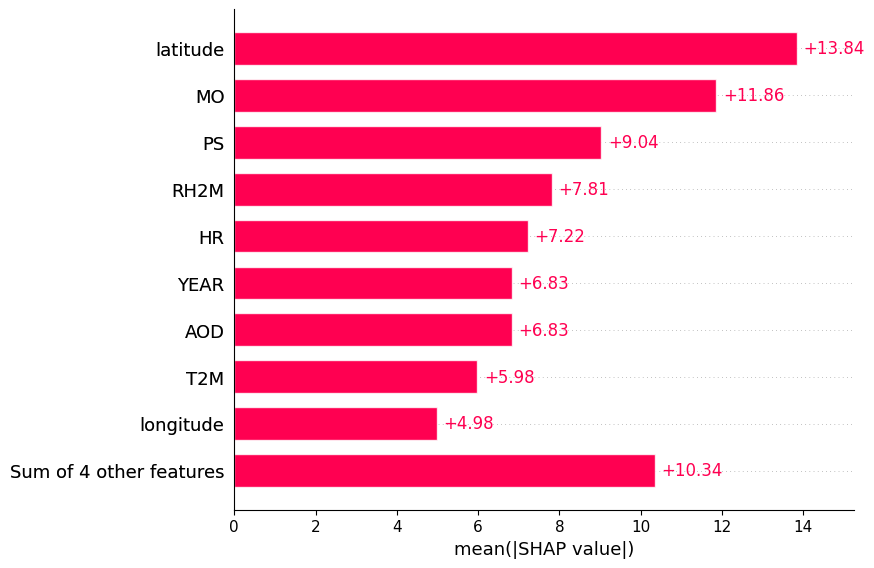

In [ ]:
import shap

# Sample 1000 rows from test data
X_sample = X_test.sample(1000, random_state=42)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the sample
shap_values = explainer(X_sample)

# Plot bar plot of feature importances (top 10 by default)
shap.plots.bar(shap_values, max_display=10)

# Predicting on testing Dataframe and Plotting HeatMap for PM2.5

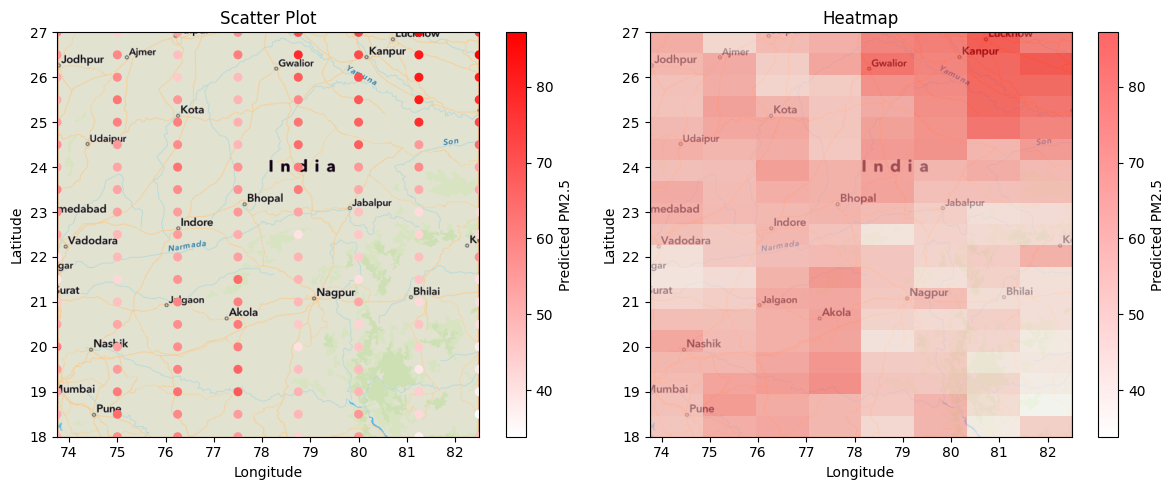

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import requests
from io import BytesIO

#  Define your custom colormap
white_red = LinearSegmentedColormap.from_list('white_red', ['white', 'red'])

#  Load your background map image from Google Drive
file_id = '1FAbvqXcWswZqv6po7EIT_4ZCXd34ALXG'
download_url = f'https://drive.google.com/uc?id={file_id}'
response = requests.get(download_url)
img = Image.open(BytesIO(response.content))
map_img = np.array(img)

#  Prepare test data (assuming df_testing and model are already defined)
test_df_clean = df_testing.copy()
test_df_clean = test_df_clean.drop(columns=["time"], errors="ignore")
test_df_clean = test_df_clean.dropna()
X_test_new = test_df_clean[X_train.columns]

#  Predict PM2.5
y_pred_new = model.predict(X_test_new)
test_df_clean["Predicted_PM2.5"] = y_pred_new

#  Prepare heatmap data
heatmap_df = test_df_clean.pivot_table(index='latitude', columns='longitude', values='Predicted_PM2.5')

#  Determine extent
lon_min, lon_max = heatmap_df.columns.min(), heatmap_df.columns.max()
lat_min, lat_max = heatmap_df.index.min(), heatmap_df.index.max()
extent = [lon_min, lon_max, lat_min, lat_max]

#  Plot both scatter and heatmap on map in same figure
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#  Scatter plot
axes[0].imshow(map_img, extent=extent, aspect='auto')
sc = axes[0].scatter(test_df_clean['longitude'], test_df_clean['latitude'],
                     c=test_df_clean['Predicted_PM2.5'], cmap=white_red, s=30)
axes[0].set_title('Scatter Plot')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(sc, ax=axes[0], label='Predicted PM2.5')

#  Heatmap
axes[1].imshow(map_img, extent=extent, aspect='auto')
im = axes[1].imshow(heatmap_df, cmap=white_red, aspect='auto', extent=extent,
                    origin='lower', alpha=0.6)
axes[1].set_title('Heatmap')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im, ax=axes[1], label='Predicted PM2.5')

plt.tight_layout()
plt.show()
